# Homework 02: ELEc 576
# Name: Youssaf Menacer

In [4]:
import numpy as np
from sklearn import datasets, linear_model
import matplotlib.pyplot as plt

In [5]:
def generate_data():
    '''
    gererate training data
    :return: X as input data and y as the target data
    '''
    np.random.seed(0)
    X, y = datasets.make_moons(200, noise = 0.20)
    return X,y

def plot_decision_boundary(pred_func, X, y):
    '''
    Plots the decision boundary
    :param pred_func: function used to predict the target data
    :param X: input data
    :param y: given target data
    :return: the graph of decision boundary
    '''
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral) 
    plt.show()

class NeuralNetwork(object):
    '''
    Build and train the Neural Netwrok
    '''
    def __init__(self, nn_input_dim, nn_hidden_dim, nn_output_dim, 
                 actFun_type, reg_lambda = 0.01, seed = 0):
        '''
        :param nn_input_dim: input dimension
        :param nn_hidden_dim: the number of hidden units
        :param nn_output_dim: output dimension
        :param actFun_type: type of activation function. 
                            3 options: 'tanh', 'sigmoid', 'relu'
        :param reg_lambda: regularization coefficient
        :param seed: random seed
        '''
        self.nn_input_dim = nn_input_dim
        self.nn_hidden_dim = nn_hidden_dim
        self.nn_output_dim = nn_output_dim
        self.actFun_type = actFun_type
        self.reg_lambda = reg_lambda
        
        #initialize the weigths and biases in the network
        np.random.seed(seed)
        self.W1 = np.random.randn(self.nn_input_dim, 
                                  self.nn_hidden_dim) / np.sqrt(self.nn_input_dim)
        self.b1 = np.zeros((1, self.nn_hidden_dim))
        self.W2 = np.random.randn(self.nn_hidden_dim, 
                                  self.nn_output_dim) / np.sqrt(self.nn_hidden_dim)
        self.b2 = np.zeros((1, self.nn_output_dim))

    def actFun(self, z, type):
        '''
        actFun computes the activation functions
        :param z: net input
        :param type: Tanh, Sigmoid, or ReLU
        :return: activations
        '''
        if type is "relu": return np.maximum(0, z)
        elif type is "sigmoid": return 1 / (1 + np.exp(-z))
        elif type is "tanh": return np.tanh(z)
        elif type is "softmax": return np.exp(z)/np.sum(np.exp(z), axis = 1, keepdims = True)
        else: raise Exception('Non-supported activation function')
            
    def diff_actFun(self, z, type):
        '''
        :param z: net input
        :param type: Tanh, Sigmoid, or ReLU
        :return: the derivatives of the activation functions wrt the net input
        '''
        if type is "relu": return np.heaviside(z, 1)
        elif type is "sigmoid": return np.exp(-z) / (1 + np.exp(-z))**2
        elif type is "tanh": return 1 - (np.tanh(z))**2
        else: raise Exception('Non-supported activation function')
               
    def feedForward(self, X, actFun):
        '''
        feefForward builds a 3-layer neural network and computes the two 
        probabilites, one for class 0 and one for class 1
        :param X: input data
        :param actFund: activation function
        :retur:
        '''
        self.z1 = np.dot(X, self.W1) + self.b1
        self.a1 = self.actFun(self.z1, type=self.actFun_type)
        self.z2 = np.dot(self.a1, self.W2) + self.b2
        self.probs = self.actFun(self.z2, type='softmax')
        return self.probs
    
    def predict(self, X):
        '''
        predict infers the label of a given data point X
        :param X: input data
        :return: label inferred
        '''
        self.feedForward(X, lambda x: self.actFun(x, type=self.actFun_type))
        return np.argmax(self.probs, axis=1)
    
    def calculate_loss(self, X, y):
        '''
        calculate_loss computes the loss for prediction
        :param X: input data
        :param y: target data
        :return: the loss for prediction
        '''
        num_examples = len(X)
        self.feedForward(X, lambda x: self.actFun(x, type=self.actFun_type))
        # Calculating the loss       
        data_loss = - np.sum(np.multiply(y, np.log(self.probs[range(num_examples), y])))

        # Add regulatization term to loss (optional)
        data_loss += (self.reg_lambda/2) * (np.sum(np.square(self.W1)) + 
                                            np.sum(np.square(self.W2)))      
        return (1. / num_examples) * data_loss
       
    def backprop(self, X, y):
        '''
        backprop runs backpropagation to compute the gradients 
        and update the weights and bias
        :param X: input data
        :param y: target data
        :return: dL/dW1, dL/db1, dL/dW2, dL/db2
        '''           
        delta3 = self.probs 
        delta3[range(len(X)), y] -= 1 #delta3 = dl/dz = y_hat - y
        dW2 = np.dot(self.a1.T,  delta3) #dL/dW2 = (a1.T).delta3
        db2 = np.sum(delta3, axis = 0, keepdims = True) #dL/db2 = delta3
        delta2 = np.dot(delta3, self.W2.T) * self.diff_actFun(self.z1, type=self.actFun_type) #delta2 = (delta3.(W.T))*f'(z)
        dW1 = np.dot(X.T, delta2) #dL/dW1 = (X.T).delta2
        db1 = np.sum(delta2, axis = 0) #dL/db1 = delta2
        return dW1, dW2, db1, db2
    
    def fit_model(self, X, y, learningRate = 0.001, epochs = 20000, 
                  print_loss = True):
        '''
        fit_model uses backpropagation to train the network
        :param X: input data
        :param y: target data
        :param epochs: the iteration number
        :param print_loss: print the loss or not
        :return:
        '''
        losses = [] #to store all the loss at each iteration
        #Gradient Descent
        for i in range(0, epochs):
            #Forward propagation
            self.feedForward(X, lambda x: self.actFun(x, type=self.actFun_type))
            #Backpropagation
            dW1, dW2, db1, db2 = self.backprop(X,y)
                        
            #Add deriativatives of regularization terms with the weights
            dW2 += self.reg_lambda * self.W2
            dW1 += self.reg_lambda * self.W1
            
            #Gradient descent parameter updata
            self.W1 -= learningRate * dW1
            self.b1 -= learningRate * db1
            self.W2 -= learningRate * dW2
            self.b2 -= learningRate * db2
            
            losses.append(self.calculate_loss(X, y))         
                
            if print_loss and i % 1000 == 0:
                print("Loss after iteration %i: %f" % (i, self.calculate_loss(X, y)))
                        
        #plots the loss function with respect to the epoch
        plt.figure()
        plt.plot([i for i in range(epochs)], losses)
        plt.xlabel('epochs')
        plt.ylabel('Loss')
        plt.title('The loss function')
        plt.show()
            
    def visualize_decision_boundary(self, X, y):
        '''
        visualize_decision_boundary plot the decision boundary created by the trained network
        :param X: input data
        :param y: given labels
        :return:
        '''
        plot_decision_boundary(lambda x: self.predict(x), X, y)

<>:69: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:70: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:71: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:72: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:81: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:82: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:83: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:69: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:70: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:71: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:72: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:81: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:82: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:83: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-5-ec85aec0ae62>:69: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if type is "relu": return np.maximum(0, 

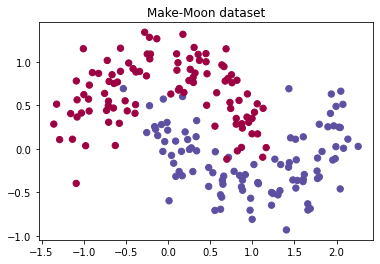

Loss after iteration 0: 0.287876
Loss after iteration 1000: 0.059349
Loss after iteration 2000: 0.044778
Loss after iteration 3000: 0.042237
Loss after iteration 4000: 0.041221
Loss after iteration 5000: 0.040568
Loss after iteration 6000: 0.040015
Loss after iteration 7000: 0.039495
Loss after iteration 8000: 0.038995
Loss after iteration 9000: 0.038502
Loss after iteration 10000: 0.038029
Loss after iteration 11000: 0.037624
Loss after iteration 12000: 0.037311
Loss after iteration 13000: 0.037078
Loss after iteration 14000: 0.036903
Loss after iteration 15000: 0.036768
Loss after iteration 16000: 0.036661
Loss after iteration 17000: 0.036575
Loss after iteration 18000: 0.036504
Loss after iteration 19000: 0.036446


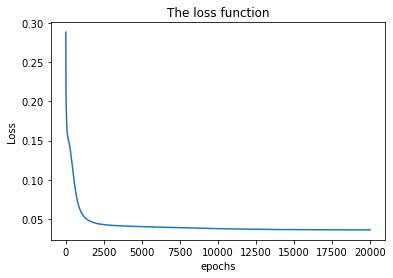

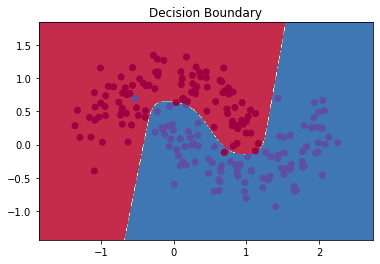

In [6]:
import numpy as np
def main():
    # generate and visualize Make-Moons dataset
    X, y = generate_data()
    plt.scatter(X[:, 0], X[:, 1], s=40, c=y, cmap=plt.cm.Spectral)
    plt.title('Make-Moon dataset')
    plt.show()

    model = NeuralNetwork(nn_input_dim= 2, nn_hidden_dim= 4, 
                          nn_output_dim= 2,
                          actFun_type= 'tanh')
    model.fit_model(X,y)
    plt.title('Decision Boundary')
    model.visualize_decision_boundary(X,y)

if __name__ == "__main__":
    main()        